In [1]:
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.9 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from tqdm import tqdm

In [2]:
rs = 2023

In [3]:
df = pd.read_csv('/bigdata/data/7/aug_train.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,17163,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,32023,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,87447,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,501933,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


In [4]:
df.shape

(382154, 12)

In [5]:
df.drop(columns=['id'], inplace=True)

In [6]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


In [7]:
df['Driving_License'] = df['Driving_License'].apply(lambda x: 'Yes' if x == 1 else 'No')
df['Previously_Insured'] = df['Previously_Insured'].apply(lambda x: 'Yes' if x == 1 else 'No')
df['Region_Code'] = df['Region_Code'].apply(lambda x: str(int(x)))
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,22,Yes,7,Yes,< 1 Year,No,2630.0,152.0,16,0
1,Male,42,Yes,28,No,1-2 Year,Yes,43327.0,26.0,135,0
2,Female,66,Yes,33,No,1-2 Year,Yes,35841.0,124.0,253,0
3,Female,22,Yes,33,No,< 1 Year,No,27645.0,152.0,69,0
4,Male,28,Yes,46,Yes,< 1 Year,No,29023.0,152.0,211,0


In [8]:
cat_cols = ['Gender', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Driving_License']
num_cols = ['Age', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
target = 'Response'

In [9]:
df.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [10]:
df.Driving_License.value_counts()

Yes    381431
No        723
Name: Driving_License, dtype: int64

In [11]:
df.Vehicle_Age.value_counts()

1-2 Year     200176
< 1 Year     166353
> 2 Years     15625
Name: Vehicle_Age, dtype: int64

In [12]:
df.Region_Code.describe()

count     382154
unique        53
top           28
freq      107199
Name: Region_Code, dtype: object

In [13]:
df.Previously_Insured.value_counts()

No     195211
Yes    186943
Name: Previously_Insured, dtype: int64

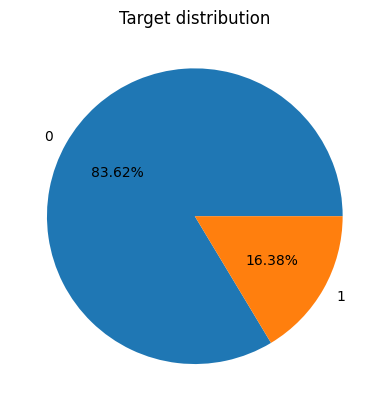

In [14]:
plt.pie(df[target].value_counts(), labels=[0, 1], autopct='%.2f%%')
plt.title('Target distribution')
plt.show()

In [15]:
X_train, X_test, y_train, y_test = tts(df.drop(columns=[target]), df[target], test_size=0.25, stratify=df[target], random_state=rs)

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), cat_cols)
    ])

In [121]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), cat_cols)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rfc', RandomForestClassifier(criterion='log_loss', random_state=rs))
])

param_grid = {
    'rfc__n_estimators': [200, 400, 600, 800],
    'rfc__max_depth': np.arange(5, 18, 2)
}

grid_search_rfc = GridSearchCV(pipeline,
                              param_grid,
                              cv=StratifiedKFold(n_splits=3),
                              scoring='roc_auc',
                              n_jobs=-1,
                              refit=False)


grid_search_rfc.fit(X_train, y_train)


print("Наилучшие параметры модели:", {k.replace('rfc__', ''): v for k, v in grid_search_rfc.best_params_.items()})
print("ROC AUC наилучшей модели:", grid_search_rfc.best_score_)

Наилучшие параметры модели: {'max_depth': 17, 'n_estimators': 600}
ROC AUC наилучшей модели: 0.8623645188963617


In [57]:
pd.DataFrame(grid_search_rfc.cv_results_).drop(columns=['params'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__max_depth,param_rfc__n_estimators,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,42.101501,0.113622,4.294820,0.020309,9,400,0.862239,0.859552,0.862625,0.861472,0.001367,12
1,60.296016,0.989459,7.797405,1.015660,9,600,0.862294,0.859628,0.862705,0.861542,0.001364,10
2,78.611421,0.703584,9.506901,0.562852,9,800,0.862292,0.859441,0.862688,0.861474,0.001447,11
3,41.187702,0.600207,5.486770,1.247485,11,400,0.863133,0.860242,0.863792,0.862389,0.001542,9
4,61.033446,0.728518,7.515766,0.856302,11,600,0.863109,0.860288,0.863839,0.862412,0.001531,8
5,81.634315,0.960219,9.762321,0.249521,11,800,0.863141,0.860291,0.863824,0.862419,0.001530,7
6,41.448550,0.692487,6.524133,0.584578,13,400,0.863059,0.860320,0.864171,0.862517,0.001618,3
7,62.989632,1.969663,7.969528,1.048588,13,600,0.862984,0.860314,0.864247,0.862515,0.001640,4
8,83.478474,2.199002,11.023077,0.441072,13,800,0.863015,0.860282,0.864269,0.862522,0.001665,2
9,41.813131,1.250812,5.615682,0.864657,15,400,0.862835,0.860401,0.864302,0.862513,0.001609,5


In [18]:
clf_rfc = RandomForestClassifier(
    n_estimators=600,
    criterion='entropy',
    max_depth=17,
    n_jobs=-1,
    random_state=rs
)
pipe_rfc = Pipeline([
    ('preprocessor', preprocessor),
    ('rfc', clf_rfc)
])

In [19]:
%%time
pipe_rfc.fit(X_train, y_train)

CPU times: total: 4min 10s
Wall time: 38.1 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['Gender', 'Region_Code',
                                                   'Previously_Insured',
                                                   'Vehicle_Age',
                                                   'Vehicle_Damage',
                                                   'Driving_License'])])),
                ('rfc',
                 RandomForestClassifier(criterion='entropy', max_depth=17,
                                        n_estimators=600, n_jobs=-1,
                                        random_state=2023))])

In [20]:
%%time
rfc_probas = pipe_rfc.predict_proba(X_test)

CPU times: total: 11.9 s
Wall time: 1.97 s


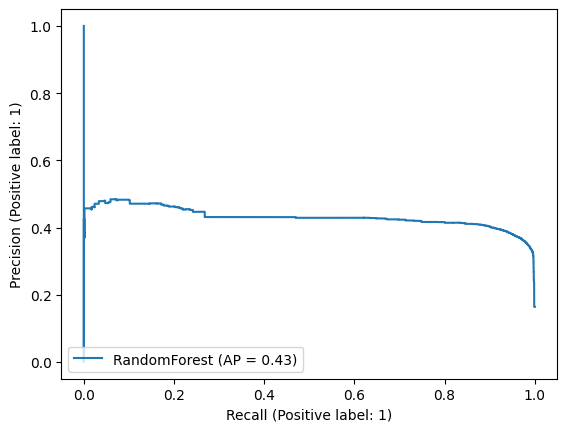

In [120]:
from sklearn.metrics import PrecisionRecallDisplay, roc_curve, auc, RocCurveDisplay


PrecisionRecallDisplay.from_predictions(y_test, rfc_probas[:, 1], name="RandomForest")

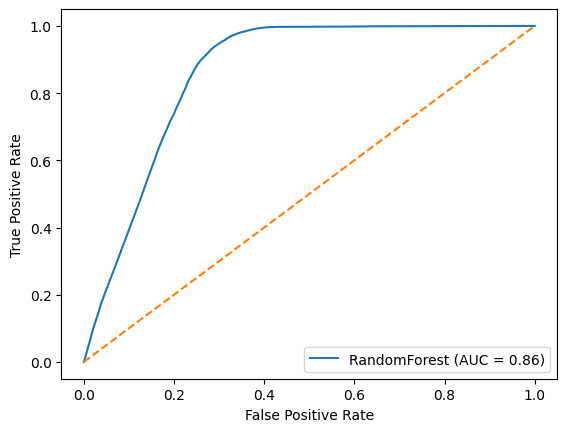

In [119]:
fpr, tpr, thresholds = roc_curve(y_test, rfc_probas[:, 1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                estimator_name='RandomForest')
display.plot()
plt.plot([0, 1], [0, 1], linestyle='dashed')
plt.show()

In [21]:
def find_threshold_f1(probas):
    max_f1 = 0
    best_thres = 0
    for i in tqdm(range(0, 1001)):
      t = i/1000
      cur_f1 = f1_score(y_test, np.where(probas[:, 1] >= t, 1, 0))
      if cur_f1 > max_f1:
        best_thres = t
        max_f1 = cur_f1
    return best_thres, max_f1

In [23]:
best_thres, max_f1 = find_threshold_f1(rfc_probas)
print(f'Лучшее пороговое значение вероятности 1 класса для максимизации F1 - {best_thres} при F1 {max_f1}')

100%|██████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:30<00:00, 33.14it/s]

Лучшее пороговое значение вероятности 1 класса для максимизации F1 - 0.282 при F1 0.5583313219084399


In [24]:
rfc_preds = np.where(rfc_probas[:, 1] >= best_thres, 1, 0)

In [25]:
f1_rfc = f1_score(y_test, rfc_preds)
pr_rfc = precision_score(y_test, rfc_preds)
rec_rfc = recall_score(y_test, rfc_preds)
roc_auc_rfc = roc_auc_score(y_test, rfc_probas[:, 1])
print('RandomForestClassfifer:')
print('F1: ', f1_rfc)
print('Precision: ', pr_rfc)
print('Recall: ', rec_rfc)
print('ROC AUC: ', roc_auc_rfc)

RandomForestClassfifer:
F1:  0.5583313219084399
Precision:  0.40741501790641693
Recall:  0.8868370607028754
ROC AUC:  0.8617591168928999


In [ ]:
model = CatBoostClassifier(
    iterations=5000,
    early_stopping_rounds=100,
    task_type='GPU',
    thread_count=-1,
    cat_features=cat_cols,
    loss_function='Logloss',
    random_seed=rs,
    verbose=False
    )

grid = {'learning_rate': [0.05, 0.1],
        'max_depth': [2, 6, 10],
        'l2_leaf_reg': [1, 3]}

grid_search_result = model.grid_search(grid,
                                       X=X_train,
                                       y=y_train,
                                       partition_random_seed=rs,
                                       cv=StratifiedKFold(n_splits=3),
                                       refit=False,
                                       verbose=True
                                       )

bestTest = 0.2725664082
bestIteration = 3596
0:	loss: 0.2725664	best: 0.2725664 (0)	total: 1m 52s	remaining: 20m 35s
bestTest = 0.2724635951
bestIteration = 2289
1:	loss: 0.2724636	best: 0.2724636 (1)	total: 3m 4s	remaining: 15m 20s
bestTest = 0.2725326767
bestIteration = 3564
2:	loss: 0.2725327	best: 0.2724636 (1)	total: 4m 56s	remaining: 14m 48s
bestTest = 0.2724986555
bestIteration = 2108
3:	loss: 0.2724987	best: 0.2724636 (1)	total: 6m 4s	remaining: 12m 8s
bestTest = 0.2715634908
bestIteration = 1489
4:	loss: 0.2715635	best: 0.2715635 (4)	total: 7m 36s	remaining: 10m 39s
bestTest = 0.2716081425
bestIteration = 744
5:	loss: 0.2716081	best: 0.2715635 (4)	total: 8m 27s	remaining: 8m 27s
bestTest = 0.2714219035
bestIteration = 1394
6:	loss: 0.2714219	best: 0.2714219 (6)	total: 9m 59s	remaining: 7m 8s
bestTest = 0.2715760635
bestIteration = 529
7:	loss: 0.2715761	best: 0.2714219 (6)	total: 10m 38s	remaining: 5m 19s
bestTest = 0.271688519
bestIteration = 454
8:	loss: 0.2716885	best: 0.27

In [26]:
model = CatBoostClassifier(
    iterations=5000,
    early_stopping_rounds=100,
    task_type='GPU',
    thread_count=-1,
    cat_features=cat_cols,
    loss_function='Logloss',
    random_seed=rs,
    use_best_model=True,
    verbose=500,
    learning_rate=0.05,
    max_depth=6,
    l2_leaf_reg=3,
    eval_metric='AUC'
    )

In [27]:
%%time
model.fit(X_train,
         y=y_train,
         eval_set=(X_test, y_test))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8686555	best: 0.8686555 (0)	total: 59.9ms	remaining: 4m 59s
500:	test: 0.8967339	best: 0.8967339 (500)	total: 29.6s	remaining: 4m 25s
bestTest = 0.8969237208
bestIteration = 825
Shrink model to first 826 iterations.
CPU times: total: 1min 20s
Wall time: 1min


In [28]:
%%time
cb_probas = model.predict_proba(X_test)

CPU times: total: 1.67 s
Wall time: 453 ms


In [29]:
best_thres, max_f1 = find_threshold_f1(cb_probas)
print(f'Лучшее пороговое значение вероятности 1 класса для максимизации F1 - {best_thres} при F1 {max_f1}')

100%|██████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:30<00:00, 33.35it/s]

Лучшее пороговое значение вероятности 1 класса для максимизации F1 - 0.338 при F1 0.6120600541471819


In [30]:
cb_preds = np.where(cb_probas[:, 1] > best_thres, 1, 0)

In [31]:
f1_cb = f1_score(y_test, cb_preds)
pr_cb = precision_score(y_test, cb_preds)
rec_cb = recall_score(y_test, cb_preds)
roc_auc_cb = roc_auc_score(y_test, cb_probas[:, 1])
print('CatBoostClassifier:')
print('F1: ', f1_cb)
print('Precision: ', pr_cb)
print('Recall: ', rec_cb)
print('ROC AUC: ', roc_auc_cb)

CatBoostClassifier:
F1:  0.6120600541471819
Precision:  0.4977582065652522
Recall:  0.7945047923322683
ROC AUC:  0.8969237636709751
